In [1]:
import pandas as pd
import numpy as np
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
base_dir = "Data/"

label2one = {'B':0,'S':1,'X':2}
one2label = {0:'B', 1:'S', 2:'X'}

def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mu, std, (data-mu)/std

vfunc = np.vectorize(lambda x:label2one[x])

input_labels = ['pitcher','batter','balls', 'strikes','inning','pitch_count']

feature_length = len(input_labels)-2
print("Feature length:{}".format(feature_length))
train_years = [4,5,6]
dev_years = [7]


train_x = {}
train_y = {}
ctr = 0
for y in train_years:
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_RegularSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)

    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)
    
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_PostSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)
    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_RegularSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)
test_x = f2[input_labels]
test_y = f2['umpcall']

test_x = test_x.as_matrix()
test_y = test_y.as_matrix()
test_y = vfunc(test_y)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_PostSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)

tmp_x = f2[input_labels]
tmp_y = f2['umpcall']

tmp_x = tmp_x.as_matrix()
tmp_y = tmp_y.as_matrix()
tmp_y = vfunc(tmp_y)

test_x = np.concatenate((test_x, tmp_x), axis=0)
test_y = np.concatenate((test_y, tmp_y), axis=0)

Feature length:4
Loading Data/MLB_2014/MLB_PitchFX_2014_RegularSeason.csv
Loading Data/MLB_2014/MLB_PitchFX_2014_PostSeason.csv
(658428, 6)
(8837, 6)
Loading Data/MLB_2015/MLB_PitchFX_2015_RegularSeason.csv
(667265, 6)
(672271, 6)
Loading Data/MLB_2015/MLB_PitchFX_2015_PostSeason.csv
(1339536, 6)
(10277, 6)
Loading Data/MLB_2016/MLB_PitchFX_2016_RegularSeason.csv
(1349813, 6)
(703809, 6)
Loading Data/MLB_2016/MLB_PitchFX_2016_PostSeason.csv
(2053622, 6)
(10076, 6)
Loading test file Data/MLB_2017/MLB_PitchFX_2017_RegularSeason.csv
Loading test file Data/MLB_2017/MLB_PitchFX_2017_PostSeason.csv


In [3]:
vv = np.vectorize(lambda x: (isinstance(x, float) and math.isnan(x) ))
idx = ~np.logical_or(vv(train_x[:,0]), vv(train_x[:,1]))
train_x = train_x[idx]
train_y = train_y[idx]

In [4]:
from sklearn.model_selection import train_test_split
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0, shuffle=True)

In [5]:
train_x[0,:]

array(['conlead01', 'duvalad01', 0, 1, 4, 56], dtype=object)

In [6]:
class Lang:
    def __init__(self, name):
        """Init Lang with a name."""
        self.name = name
        self.word2index = {"<UNK>": 0}
        self.word2count = {}
        self.index2word = {0: "<UNK>"}
        self.n_words = 1  # Count SOS and EOS

    def addword(self, word):
        """Add a word to the dict."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [1]:
def map2idx(train_x, pl, bl):
    pi = train_x[:,0]
    vfnc = np.vectorize(lambda x: pl.word2index[x] if x in pitch_lang.word2index else 0)
    pi = vfnc(pi).reshape(-1,1)
    vfnc = np.vectorize(lambda x:bl.word2index[x] if x in batter_lang.word2index else 0)
    ba = vfnc(train_x[:,1]).reshape(-1,1)
    
    return np.concatenate((pi,ba,train_x[:,2:]), axis=1)

def data_gen(dx, df, dy, batch_size=100):
    idx = 0
    while True:
        if idx*batch_size >= dx.shape[0]:
            return
        elif (idx+1)*batch_size > dx.shape[0]:
            yield dx[idx*batch_size:,:], df[idx*batch_size:,:], dy[idx*batch_size:]
        else:
            yield dx[idx*batch_size:(idx+1)*batch_size,:], df[idx*batch_size:(idx+1)*batch_size], dy[idx*batch_size:(idx+1)*batch_size]
        idx += 1


def train(train_x, train_f, train_y, dev_x, dev_f, dev_y, model, scheduler, optimizer, criterion, batch_size=512, max_epoch = 512, validation_interv=1000):
    for ep in range(max_epoch):
        print("Epoch {}".format(ep+1))
        scheduler.step()
        train_iter = data_gen(train_x, train_f, train_y, batch_size=batch_size)
        ctr = 0
        avg_loss = 0
        model.train()
        for bx,bf,by in train_iter:
            optimizer.zero_grad()
            y_pred = model(bx,bf)
            loss = criterion(y_pred, by)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_( model.parameters(), 2)
            avg_loss += loss.item()*bx.shape[0]
            optimizer.step()
            ctr+= bx.shape[0]
        #dy_pred = model(dev_x, dev_f)
        model.eval()
        ll = 0
        ctrr = 0
        acc = 0
        for dx,df,dy in data_gen(dev_x, dev_f, dev_y, batch_size=batch_size):
            dy_pred = model(dx, df)
            tmp = criterion(dy_pred, dy).item()
            ll += tmp * dx.shape[0]
            ctrr += dx.shape[0]
            mv, mi = torch.max(dy_pred, 1)
            acc += torch.sum( mi == dy ).item()
        
        print("loss:{} dev_loss:{}, dev_acc:{}".format(avg_loss/ctr, ll/ctrr, acc / ctrr))


In [8]:
pitch_lang = Lang('pitcher')
batter_lang = Lang('batter')
player_lang = Lang('player')
pits = train_x[:,0]
bats = train_x[:,1]
for i in range(len(train_x)):
    pitch_lang.addword(pits[i])
    batter_lang.addword(bats[i])
    player_lang.addword(pits[i])    
    player_lang.addword(bats[i])

In [9]:
DEVICE = torch.device('cuda')

In [10]:

vtx = Variable(torch.from_numpy(map2idx(train_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vtf = Variable(torch.from_numpy(train_x[:,2:].astype(np.long))).to(DEVICE)
vty = Variable(torch.from_numpy(train_y)).to(DEVICE)
vdx = Variable(torch.from_numpy(map2idx(dev_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vdf = Variable(torch.from_numpy(dev_x[:,2:].astype(np.long))).to(DEVICE)
vdy = Variable(torch.from_numpy(dev_y)).to(DEVICE)

vtestx = Variable(torch.from_numpy(map2idx(test_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vtestf = Variable(torch.from_numpy(test_x[:,2:].astype(np.long))).to(DEVICE)
vtesty = Variable(torch.from_numpy(test_y)).to(DEVICE)


# Model 2

In [11]:
class PlayerEmbedding(nn.Module):
    """The class for embedding records.
    This class is for embedding the docvec (r.t, r.e, r.m)
    into a high dimension space.
    Attributes:
        embedding1: embedding for r.t
        embedding2: embedding for r.e
        linear: A linear layer mapping [r.t, r.e, r.m] back to one space
    """

    def __init__(self, pitcher_size, batter_size, embedding_dim):
        super(PlayerEmbedding, self).__init__()
        self.embedding1 = nn.Embedding(pitcher_size, embedding_dim)
        self.embedding2 = nn.Embedding(batter_size, embedding_dim)
        self.embedding_dim = embedding_dim

    def forward(self, p, b):
        emb_p = self.embedding1(p)
        emb_b = self.embedding2(b)

        emb_all = torch.cat([emb_p, emb_b], dim=1)
        return emb_all

    def init_weights(self):
        initrange = 0.1
        em_layer = [self.embedding1, self.embedding2]

        for layer in em_layer:
            layer.weight.data.normal_(0, initrange)

class Fcc(nn.Module):
    def __init__(self, embedding_layer):
        super(Fcc, self).__init__()
        p=0.1
        self.embedding = embedding_layer
        self.drop_emb = nn.Dropout(p)
        self.drop1 = nn.Dropout(p)
        self.drop2 = nn.Dropout(p)
        self.drop3 = nn.Dropout(p)
        self.drop4 = nn.Dropout(p)
        self.lin1 = nn.Linear(2*self.embedding.embedding_dim + 8, 100)
        self.act1 = nn.SELU()
        self.lin2 = nn.Linear(100, 100)
        self.act2 = nn.SELU()
        self.lin3 = nn.Linear(100, 100)
        
        self.act3 = nn.SELU()
        self.lin4 = nn.Linear(100, 100)
        self.act4 = nn.SELU()
        self.lin5 = nn.Linear(100, 3)
        
        self.emb_balls = nn.Embedding(10 , 2)
        self.emb_strikes = nn.Embedding(10 , 2)
        self.emb_inning = nn.Embedding(20 , 2)
        self.emb_pitctr = nn.Embedding(500 , 2)
        #self.lin4 = nn.Linear(100, 3)

    def forward(self, players, features):
        embedded = self.embedding(players[:,0], players[:,1])
        eb_ball = self.emb_balls(features[:,0])
        eb_st = self.emb_strikes(features[:,1])
        eb_inning = self.emb_inning(features[:,2])
        eb_pit = self.emb_pitctr(features[:,3])
        output = torch.cat([embedded, eb_ball, eb_st, eb_inning, eb_pit], dim=1)
        #output = self.drop_emb(output)
        
        output = self.lin1(output)
        output = self.act1(output)
        output = self.drop1(output)
        
        output = self.lin2(output)
        output = self.act2(output)
        output = self.drop2(output)
        
        output = self.lin3(output)
        output = self.act3(output)
        output = self.drop3(output)
        
        output = self.lin4(output)
        output = self.act4(output)
        output = self.drop4(output)
        
        output = self.lin5(output)
        
        output = F.log_softmax(output, dim=1)
        return output

In [12]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 20).to(DEVICE)
model = Fcc(emb_layer).to(DEVICE)
print(model)

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 20)
    (embedding2): Embedding(1409, 20)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=48, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)


In [13]:
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, dampening=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)
#opt = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0)
crit = nn.NLLLoss()
train(vtx, vtf, vty, vdx, vdf, vdy, model, scheduler, opt, crit, max_epoch=1000, batch_size=4096*16)

Epoch 1
loss:1.0508015747068586 dev_loss:1.033812265640579, dev_acc:0.45776033338179
Epoch 2
loss:1.0352469937649766 dev_loss:1.0295260979326657, dev_acc:0.45977613025149006
Epoch 3
loss:1.032776429162849 dev_loss:1.02829929465742, dev_acc:0.4599990308668896
Epoch 4
loss:1.031804482280424 dev_loss:1.027563616169708, dev_acc:0.46005233318796335
Epoch 5
loss:1.0311326830319933 dev_loss:1.0270843591963639, dev_acc:0.4601444008334545
Epoch 6
loss:1.0308346870936864 dev_loss:1.0267687128964635, dev_acc:0.4602994621311237
Epoch 7
loss:1.0305694094446325 dev_loss:1.0265754035942867, dev_acc:0.46033822745554104
Epoch 8
loss:1.030305031979087 dev_loss:1.026465106734808, dev_acc:0.460396375442167
Epoch 9
loss:1.0303162673747832 dev_loss:1.0264153207117268, dev_acc:0.46046906042544944
Epoch 10
loss:1.0302275907602774 dev_loss:1.0264029785096083, dev_acc:0.4604787517565538
Epoch 11
loss:1.030227391283968 dev_loss:1.0264029785096083, dev_acc:0.4604787517565538
Epoch 12
loss:1.0301921319502716 dev_l

loss:1.0256525018051836 dev_loss:1.0230325760684018, dev_acc:0.4646944807869361
Epoch 95
loss:1.0256793004330285 dev_loss:1.023025162536437, dev_acc:0.4646654067936231
Epoch 96
loss:1.0256613841228979 dev_loss:1.0230175146086362, dev_acc:0.4647962397635315
Epoch 97
loss:1.0256399377275136 dev_loss:1.023008275080566, dev_acc:0.4648253137568445
Epoch 98
loss:1.025533724750075 dev_loss:1.0229946916865975, dev_acc:0.46473809177690556
Epoch 99
loss:1.0255683970394052 dev_loss:1.0229805050267322, dev_acc:0.4649076900712313
Epoch 100
loss:1.0255314884701474 dev_loss:1.0229640210651638, dev_acc:0.46496583805785724
Epoch 101
loss:1.0255261360477046 dev_loss:1.022946698687454, dev_acc:0.46504821437224403
Epoch 102
loss:1.0255355940231685 dev_loss:1.0229374551366406, dev_acc:0.4650385230411397
Epoch 103
loss:1.0253717790436963 dev_loss:1.022922111798345, dev_acc:0.46507244270000486
Epoch 104
loss:1.0254518852072618 dev_loss:1.0229110945829005, dev_acc:0.4650094490478267
Epoch 105
loss:1.025388861

loss:1.024609716964904 dev_loss:1.0224073511076428, dev_acc:0.46575083587730776
Epoch 187
loss:1.024581182233362 dev_loss:1.0224034735553051, dev_acc:0.46573629888065127
Epoch 188
loss:1.0245613681990007 dev_loss:1.0224009024921865, dev_acc:0.46566845956292097
Epoch 189
loss:1.0245195216285883 dev_loss:1.0223998102850882, dev_acc:0.46568299655957746
Epoch 190
loss:1.0245466028669556 dev_loss:1.0223994792359752, dev_acc:0.46566845956292097
Epoch 191
loss:1.024554723958344 dev_loss:1.0223994792359752, dev_acc:0.46566845956292097
Epoch 192
loss:1.0245511467143418 dev_loss:1.0223992899521646, dev_acc:0.4656539225662645
Epoch 193
loss:1.0246533997864002 dev_loss:1.0223985706736842, dev_acc:0.4656587682318166
Epoch 194
loss:1.0245161766066606 dev_loss:1.0223959682188437, dev_acc:0.46562969423850364
Epoch 195
loss:1.0245556274064676 dev_loss:1.0223928977625543, dev_acc:0.4656539225662645
Epoch 196
loss:1.024550399742852 dev_loss:1.0223861382475148, dev_acc:0.4656636138973688
Epoch 197
loss:1.

loss:1.023981594418485 dev_loss:1.0219609529396623, dev_acc:0.46611426079372004
Epoch 279
loss:1.0240097628507487 dev_loss:1.0219544343213134, dev_acc:0.4661530261181373
Epoch 280
loss:1.0239777299910344 dev_loss:1.0219445987109812, dev_acc:0.46602703881378105
Epoch 281
loss:1.0239789947003102 dev_loss:1.021936313754893, dev_acc:0.46599796482046807
Epoch 282
loss:1.0240003846688892 dev_loss:1.021930271147665, dev_acc:0.46609487813151135
Epoch 283
loss:1.02397942277568 dev_loss:1.0219210815445863, dev_acc:0.4661045694626157
Epoch 284
loss:1.0239683264357515 dev_loss:1.0219147167597686, dev_acc:0.46620148277365897
Epoch 285
loss:1.0239252720254761 dev_loss:1.0219090590777598, dev_acc:0.46616271744924165
Epoch 286
loss:1.0239644035604945 dev_loss:1.0219059000494939, dev_acc:0.4661821001114503
Epoch 287
loss:1.0239354919646029 dev_loss:1.0219016028760668, dev_acc:0.4661917914425546
Epoch 288
loss:1.023926210895548 dev_loss:1.0218990068504525, dev_acc:0.4662063284392111
Epoch 289
loss:1.023

loss:1.0235917907207146 dev_loss:1.021577608619439, dev_acc:0.4662208654358676
Epoch 371
loss:1.0235961478729805 dev_loss:1.021577608619439, dev_acc:0.4662208654358676
Epoch 372
loss:1.0235782379133944 dev_loss:1.0215773871178693, dev_acc:0.4662257111014198
Epoch 373
loss:1.023572386723671 dev_loss:1.0215769819714924, dev_acc:0.4661917914425546
Epoch 374
loss:1.0235797462395766 dev_loss:1.0215756835635736, dev_acc:0.4661675631147938
Epoch 375
loss:1.0235482467804076 dev_loss:1.0215731278012044, dev_acc:0.46624509376362844
Epoch 376
loss:1.0235101317822906 dev_loss:1.0215696401303087, dev_acc:0.4662741677569414
Epoch 377
loss:1.0235911748473003 dev_loss:1.0215652656270973, dev_acc:0.4662596307602849
Epoch 378
loss:1.0235524390660096 dev_loss:1.0215605899218632, dev_acc:0.46629839608470225
Epoch 379
loss:1.023517629495449 dev_loss:1.0215525118851896, dev_acc:0.46634685274022386
Epoch 380
loss:1.023565151482908 dev_loss:1.0215456863541863, dev_acc:0.4662741677569414
Epoch 381
loss:1.02353

loss:1.023317416071862 dev_loss:1.0213092794978422, dev_acc:0.46627901342249356
Epoch 463
loss:1.023289062910025 dev_loss:1.0213061816009457, dev_acc:0.46629355041915005
Epoch 464
loss:1.0232732441331607 dev_loss:1.0213026931398268, dev_acc:0.4663032417502544
Epoch 465
loss:1.0232879973566562 dev_loss:1.0212984531824687, dev_acc:0.46629839608470225
Epoch 466
loss:1.0232966825209797 dev_loss:1.021296580493892, dev_acc:0.46629355041915005
Epoch 467
loss:1.0232793380237675 dev_loss:1.0212964894796184, dev_acc:0.466322624412463
Epoch 468
loss:1.0232725656405441 dev_loss:1.0212953457312683, dev_acc:0.46631293308135874
Epoch 469
loss:1.023293978684274 dev_loss:1.0212947102117984, dev_acc:0.46631293308135874
Epoch 470
loss:1.0232605483956834 dev_loss:1.021294628859271, dev_acc:0.46630808741580654
Epoch 471
loss:1.0232953175801085 dev_loss:1.021294628859271, dev_acc:0.46630808741580654
Epoch 472
loss:1.0232484335522798 dev_loss:1.0212946344982743, dev_acc:0.466322624412463
Epoch 473
loss:1.023

loss:1.023103535550667 dev_loss:1.0211459324203582, dev_acc:0.46635169840577606
Epoch 555
loss:1.0231389814644671 dev_loss:1.0211438857129063, dev_acc:0.46627901342249356
Epoch 556
loss:1.023115808284789 dev_loss:1.0211426429047963, dev_acc:0.4662741677569414
Epoch 557
loss:1.0231382267386175 dev_loss:1.0211408572077503, dev_acc:0.4663904637301933
Epoch 558
loss:1.0231260294326143 dev_loss:1.0211365970650483, dev_acc:0.46633231574356737
Epoch 559
loss:1.0231334068417743 dev_loss:1.0211329683832588, dev_acc:0.4663565440713282
Epoch 560
loss:1.0230833235495407 dev_loss:1.0211319753075487, dev_acc:0.46638077239908904
Epoch 561
loss:1.0230419141387341 dev_loss:1.0211277651256523, dev_acc:0.4663420070746717
Epoch 562
loss:1.0230769913389401 dev_loss:1.0211243805014452, dev_acc:0.4663371614091195
Epoch 563
loss:1.023068975219463 dev_loss:1.021119563821132, dev_acc:0.4663032417502544
Epoch 564
loss:1.023049506552435 dev_loss:1.0211163548678746, dev_acc:0.46630808741580654
Epoch 565
loss:1.023

loss:1.0229380202920029 dev_loss:1.0210016636421684, dev_acc:0.466322624412463
Epoch 647
loss:1.0229910024660427 dev_loss:1.021001619320366, dev_acc:0.4662741677569414
Epoch 648
loss:1.0229641956669038 dev_loss:1.0210014356755583, dev_acc:0.466322624412463
Epoch 649
loss:1.0229493782427317 dev_loss:1.0210013092110055, dev_acc:0.46630808741580654
Epoch 650
loss:1.022942482912188 dev_loss:1.0210010933484392, dev_acc:0.46631293308135874
Epoch 651
loss:1.0230424656338126 dev_loss:1.0210010933484392, dev_acc:0.46631293308135874
Epoch 652
loss:1.0229409348365681 dev_loss:1.021001322105272, dev_acc:0.466322624412463
Epoch 653
loss:1.022937208226406 dev_loss:1.0210011360539815, dev_acc:0.4663274700780152
Epoch 654
loss:1.0229536106022814 dev_loss:1.0210005963975655, dev_acc:0.4663274700780152
Epoch 655
loss:1.0229133646196316 dev_loss:1.0209996233639425, dev_acc:0.46637592673353684
Epoch 656
loss:1.022919757323686 dev_loss:1.0209978183075896, dev_acc:0.4663710810679847
Epoch 657
loss:1.0229523

loss:1.0228685135300506 dev_loss:1.0209136751540648, dev_acc:0.4663177787469109
Epoch 739
loss:1.02284872164044 dev_loss:1.0209146481518736, dev_acc:0.4663565440713282
Epoch 740
loss:1.0228515603060635 dev_loss:1.0209100101959592, dev_acc:0.4662887047535979
Epoch 741
loss:1.0228300785267275 dev_loss:1.0209075060464698, dev_acc:0.46626932209138927
Epoch 742
loss:1.0228924530286079 dev_loss:1.0209059668493032, dev_acc:0.4663371614091195
Epoch 743
loss:1.022883944821013 dev_loss:1.02090583068719, dev_acc:0.4662741677569414
Epoch 744
loss:1.0228312348228445 dev_loss:1.0209041062289559, dev_acc:0.4663856180646412
Epoch 745
loss:1.0228202329061868 dev_loss:1.0209032717997433, dev_acc:0.4663565440713282
Epoch 746
loss:1.0228271906146038 dev_loss:1.0209023858292792, dev_acc:0.4661578717836895
Epoch 747
loss:1.0228248521611534 dev_loss:1.0209009858834892, dev_acc:0.46626932209138927
Epoch 748
loss:1.0228275431262996 dev_loss:1.0209007361869038, dev_acc:0.46627901342249356
Epoch 749
loss:1.02280

loss:1.0227063811501171 dev_loss:1.0208281095703657, dev_acc:0.4661869457770025
Epoch 831
loss:1.0227505564314807 dev_loss:1.0208281095703657, dev_acc:0.4661869457770025
Epoch 832
loss:1.0227418929631387 dev_loss:1.0208281796448868, dev_acc:0.46620148277365897
Epoch 833
loss:1.0227793999900794 dev_loss:1.0208280902468732, dev_acc:0.4661966371081068
Epoch 834
loss:1.0227239113843227 dev_loss:1.020827648859994, dev_acc:0.4661869457770025
Epoch 835
loss:1.0227394621844386 dev_loss:1.0208269376269998, dev_acc:0.4661917914425546
Epoch 836
loss:1.0227417010830415 dev_loss:1.0208257801583462, dev_acc:0.4661869457770025
Epoch 837
loss:1.0227583835770766 dev_loss:1.0208232525551788, dev_acc:0.46621601977031546
Epoch 838
loss:1.0227301151966506 dev_loss:1.0208222224129293, dev_acc:0.4662354024325241
Epoch 839
loss:1.022703879579894 dev_loss:1.0208191776735442, dev_acc:0.4662257111014198
Epoch 840
loss:1.0227222076186986 dev_loss:1.0208171688228544, dev_acc:0.4662887047535979
Epoch 841
loss:1.022

loss:1.0226617011894286 dev_loss:1.0207557293104503, dev_acc:0.46611426079372004
Epoch 923
loss:1.0226518810388432 dev_loss:1.0207524590825667, dev_acc:0.46624509376362844
Epoch 924
loss:1.0226895609260829 dev_loss:1.0207488651682761, dev_acc:0.4662887047535979
Epoch 925
loss:1.022621859150285 dev_loss:1.0207488233962134, dev_acc:0.4662208654358676
Epoch 926
loss:1.0226490294041017 dev_loss:1.0207494009093916, dev_acc:0.46617725444589814
Epoch 927
loss:1.0227004165789406 dev_loss:1.0207492132418412, dev_acc:0.4661869457770025
Epoch 928
loss:1.0226724048933935 dev_loss:1.0207488523814523, dev_acc:0.46620148277365897
Epoch 929
loss:1.0226710718182068 dev_loss:1.0207489248624564, dev_acc:0.46620148277365897
Epoch 930
loss:1.0226543906037282 dev_loss:1.0207490384327427, dev_acc:0.46620148277365897
Epoch 931
loss:1.0226393608984374 dev_loss:1.0207490384327427, dev_acc:0.46620148277365897
Epoch 932
loss:1.0226688150848844 dev_loss:1.020749011853987, dev_acc:0.4661869457770025
Epoch 933
loss:

In [14]:
print(model)
train(vtx, vtf, vty, vdx, vdf, vdy, model,scheduler, opt, crit, max_epoch=1000, batch_size=4096*8)

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 20)
    (embedding2): Embedding(1409, 20)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=48, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)
Epoch 0
loss:0.9942228475954521 dev_loss:1.020224878348635, dev_acc:0.4674662014827737
Epoch 1
loss:0.9941771808680929 dev_loss:1.0199172760422808, dev_acc:0.4678829287202597
Epoch 2
loss:0.9941704374104493 dev_loss:1.0200781124289855,

loss:0.9935756331333921 dev_loss:1.0207790151356138, dev_acc:0.46789262005136406
Epoch 85
loss:0.9937024832020368 dev_loss:1.0212462528434587, dev_acc:0.4674371274894607
Epoch 86
loss:0.9936104615507128 dev_loss:1.0213466216399871, dev_acc:0.4674032078305955
Epoch 87
loss:0.9937304475753092 dev_loss:1.0210288389816113, dev_acc:0.4677375587536948
Epoch 88
loss:0.9935945278525113 dev_loss:1.0209611622233685, dev_acc:0.46716092455298736
Epoch 89
loss:0.9936204953836647 dev_loss:1.0208057664026093, dev_acc:0.4673499055095217
Epoch 90
loss:0.9935960821641727 dev_loss:1.020546810034432, dev_acc:0.4671560788874352
Epoch 91
loss:0.9936923247216796 dev_loss:1.020863556256502, dev_acc:0.4674855841449823
Epoch 92
loss:0.993628102934336 dev_loss:1.020783538127954, dev_acc:0.4672869118573436
Epoch 93
loss:0.9936082051763031 dev_loss:1.0208809446617286, dev_acc:0.46718999854630033
Epoch 94
loss:0.993624173740883 dev_loss:1.020917893602109, dev_acc:0.4675485777971604
Epoch 95
loss:0.9935415471721435 

loss:0.9929539617326724 dev_loss:1.0215544767236966, dev_acc:0.4674032078305955
Epoch 177
loss:0.9931185595759174 dev_loss:1.021591702429264, dev_acc:0.46624509376362844
Epoch 178
loss:0.9933789089704237 dev_loss:1.021310190784323, dev_acc:0.4671318505596744
Epoch 179
loss:0.9930240682328912 dev_loss:1.0213330374892995, dev_acc:0.4675001211416388
Epoch 180
loss:0.9931766805418936 dev_loss:1.0211379890878134, dev_acc:0.46767456510151667
Epoch 181
loss:0.9932201107397808 dev_loss:1.0209826549552765, dev_acc:0.4675824974560256
Epoch 182
loss:0.9930688864514218 dev_loss:1.0217433646707599, dev_acc:0.46694771526869217
Epoch 183
loss:0.9931644819527393 dev_loss:1.021377673920616, dev_acc:0.46684111062654454
Epoch 184
loss:0.9932857929253865 dev_loss:1.0213208302316112, dev_acc:0.467001017589766
Epoch 185
loss:0.9930979571451898 dev_loss:1.0214094362130903, dev_acc:0.46665697533556233
Epoch 186
loss:0.9933173948533212 dev_loss:1.0214530472666012, dev_acc:0.4668023453021272
Epoch 187
loss:0.99

loss:0.9925486569588094 dev_loss:1.0220700306665265, dev_acc:0.4670204002519746
Epoch 269
loss:0.9927616007782984 dev_loss:1.0214633054532718, dev_acc:0.4675485777971604
Epoch 270
loss:0.9927727952851766 dev_loss:1.0217180220131241, dev_acc:0.4675001211416388
Epoch 271
loss:0.9927063466774849 dev_loss:1.02160187316113, dev_acc:0.46740805349614767
Epoch 272
loss:0.9928171744863823 dev_loss:1.0216208736223094, dev_acc:0.46709308523525706
Epoch 273
loss:0.992623228791853 dev_loss:1.0218231272569211, dev_acc:0.4666327470078015
Epoch 274
loss:0.9925921397083759 dev_loss:1.022385398431325, dev_acc:0.4662596307602849
Epoch 275
loss:0.9926480914592131 dev_loss:1.0222595698797536, dev_acc:0.4661191064592722
Epoch 276
loss:0.9926288800482822 dev_loss:1.0224068400113164, dev_acc:0.4667151233221883
Epoch 277
loss:0.9925192317005095 dev_loss:1.0222862185217436, dev_acc:0.46640015506129767
Epoch 278
loss:0.9927678886213503 dev_loss:1.0215903398399928, dev_acc:0.46727722052623927
Epoch 279
loss:0.992

loss:0.992293847868999 dev_loss:1.0220927003453901, dev_acc:0.46702524591752675
Epoch 361
loss:0.9922275280148982 dev_loss:1.02172259967757, dev_acc:0.4666908949944275
Epoch 362
loss:0.9922013967395169 dev_loss:1.022348219839912, dev_acc:0.46628385908804576
Epoch 363
loss:0.992244047841443 dev_loss:1.0222282020148135, dev_acc:0.4665406793623104
Epoch 364
loss:0.992244407271063 dev_loss:1.0222446860087302, dev_acc:0.46689441294761835
Epoch 365
loss:0.9922084967472645 dev_loss:1.0223413799393286, dev_acc:0.46703978291418324
Epoch 366
loss:0.9922091549882783 dev_loss:1.0224266894734657, dev_acc:0.46623055676697195
Epoch 367
loss:0.9922900359203155 dev_loss:1.0223698187759347, dev_acc:0.4665988273489364
Epoch 368
loss:0.9922527820427729 dev_loss:1.0226586227587513, dev_acc:0.46707854823860057
Epoch 369
loss:0.9922729888055217 dev_loss:1.0224187601766204, dev_acc:0.46727722052623927
Epoch 370
loss:0.992267482748478 dev_loss:1.0223340725444712, dev_acc:0.46740805349614767
Epoch 371
loss:0.99

loss:0.9918307352729232 dev_loss:1.021643413763531, dev_acc:0.46772302175703834
Epoch 453
loss:0.9920247442125694 dev_loss:1.0223645654535458, dev_acc:0.46682657362988805
Epoch 454
loss:0.9918362331073265 dev_loss:1.0224498556526374, dev_acc:0.46737413383728255
Epoch 455
loss:0.99174452492633 dev_loss:1.022401081425694, dev_acc:0.46711246789746574
Epoch 456
loss:0.9918142749822189 dev_loss:1.0223919460880564, dev_acc:0.46767456510151667
Epoch 457
loss:0.9918461618035446 dev_loss:1.0227887686644725, dev_acc:0.4670349372486311
Epoch 458
loss:0.9918718143429714 dev_loss:1.0226928217059716, dev_acc:0.46702524591752675
Epoch 459
loss:0.9919785566548199 dev_loss:1.0221348975236988, dev_acc:0.46729175752289576
Epoch 460
loss:0.9916155255793946 dev_loss:1.0227938248747603, dev_acc:0.46652614236565393
Epoch 461
loss:0.9917512646397814 dev_loss:1.0220383732022083, dev_acc:0.4668071909676794
Epoch 462
loss:0.9918461998056584 dev_loss:1.0217779596998993, dev_acc:0.4673014488540001
Epoch 463
loss:0

loss:0.9915804620697259 dev_loss:1.0227262115550144, dev_acc:0.46717546154964384
Epoch 544
loss:0.9915802592281618 dev_loss:1.0224186306401337, dev_acc:0.46690894994427484
Epoch 545
loss:0.9915486371672351 dev_loss:1.0227442815748937, dev_acc:0.46681203663323156
Epoch 546
loss:0.9915938824075036 dev_loss:1.0228006250042552, dev_acc:0.46682657362988805
Epoch 547
loss:0.9914707632395409 dev_loss:1.0226202838012008, dev_acc:0.46721422687406117
Epoch 548
loss:0.9915888649978438 dev_loss:1.022923866908911, dev_acc:0.4666860493288753
Epoch 549
loss:0.9915781292926394 dev_loss:1.0225127139202168, dev_acc:0.46674904298105346
Epoch 550
loss:0.9915750481171417 dev_loss:1.0227827999326917, dev_acc:0.46749042981053446
Epoch 551
loss:0.991553887671861 dev_loss:1.0232940821070688, dev_acc:0.4665212967001018
Epoch 552
loss:0.9914068257099178 dev_loss:1.0230658964667838, dev_acc:0.46682657362988805
Epoch 553
loss:0.9916804924846166 dev_loss:1.0227503026323725, dev_acc:0.4664728400445801
Epoch 554
loss

loss:0.9912451578768264 dev_loss:1.022697857561087, dev_acc:0.46655037069341476
Epoch 635
loss:0.9912336803322224 dev_loss:1.02257726085956, dev_acc:0.4666036730144885
Epoch 636
loss:0.9913084089453581 dev_loss:1.0231986644385067, dev_acc:0.46635169840577606
Epoch 637
loss:0.9911815844878716 dev_loss:1.0234548781381048, dev_acc:0.46610941512816784
Epoch 638
loss:0.9913638843997166 dev_loss:1.0230249828623843, dev_acc:0.4666036730144885
Epoch 639
loss:0.9912997602812608 dev_loss:1.0229870825663678, dev_acc:0.4656926878906818
Epoch 640
loss:0.9911920302630993 dev_loss:1.0228756508716532, dev_acc:0.46720938120850897
Epoch 641
loss:0.991014453181505 dev_loss:1.023607269984123, dev_acc:0.4664631487134758
Epoch 642
loss:0.9912572277385765 dev_loss:1.0231988548868565, dev_acc:0.46712215922857003
Epoch 643
loss:0.9911173902161307 dev_loss:1.0232701784130585, dev_acc:0.46558123758298203
Epoch 644
loss:0.9911712217970505 dev_loss:1.0228988749438976, dev_acc:0.4656733052284731
Epoch 645
loss:0.99

loss:0.9908925721134827 dev_loss:1.023460259678787, dev_acc:0.46614818045258516
Epoch 726
loss:0.9909951896009135 dev_loss:1.0234852409006963, dev_acc:0.4657896012017251
Epoch 727
loss:0.9911132908539662 dev_loss:1.023319160777099, dev_acc:0.46604157581043754
Epoch 728
loss:0.9908946197178526 dev_loss:1.023149488926188, dev_acc:0.4668217279643359
Epoch 729
loss:0.99089673476903 dev_loss:1.0234370997104902, dev_acc:0.4661917914425546
Epoch 730
loss:0.9908405297173223 dev_loss:1.0235083445147755, dev_acc:0.46636138973688035
Epoch 731
loss:0.9910239404794577 dev_loss:1.0234181953919468, dev_acc:0.4661917914425546
Epoch 732
loss:0.9909422801772687 dev_loss:1.022909395674053, dev_acc:0.46657944468672774
Epoch 733
loss:0.9910798202398293 dev_loss:1.0229825102266845, dev_acc:0.46627901342249356
Epoch 734
loss:0.9909959278861032 dev_loss:1.0231107747525319, dev_acc:0.46596404516160295
Epoch 735
loss:0.9909031838305717 dev_loss:1.0230140331624789, dev_acc:0.46655037069341476
Epoch 736
loss:0.99

loss:0.9906048120163368 dev_loss:1.02365512645839, dev_acc:0.466172408780346
Epoch 818
loss:0.9907644205750086 dev_loss:1.0233333056302427, dev_acc:0.4669331782720357
Epoch 819
loss:0.9907591773898369 dev_loss:1.023991219278927, dev_acc:0.4654649416097301
Epoch 820
loss:0.9906097864694519 dev_loss:1.0236123809681825, dev_acc:0.46679265397102293
Epoch 821
loss:0.9905716234468832 dev_loss:1.023680600711251, dev_acc:0.4659882734893638
Epoch 822
loss:0.9906570366877042 dev_loss:1.0233790222951629, dev_acc:0.4664050007268498
Epoch 823
loss:0.9907692486226072 dev_loss:1.0230499149402825, dev_acc:0.46640015506129767
Epoch 824
loss:0.9907407925026716 dev_loss:1.0230935579700953, dev_acc:0.4669331782720357
Epoch 825
loss:0.9905318113884913 dev_loss:1.02372552944534, dev_acc:0.4659446624993943
Epoch 826
loss:0.9908244308669697 dev_loss:1.0234260856547825, dev_acc:0.4661917914425546
Epoch 827
loss:0.9907361714089844 dev_loss:1.0235953911114335, dev_acc:0.46651160536899744
Epoch 828
loss:0.9907213

loss:0.9903734881917149 dev_loss:1.023940374172259, dev_acc:0.46611426079372004
Epoch 910
loss:0.9904119230985065 dev_loss:1.0239563156469342, dev_acc:0.4651742016766003
Epoch 911
loss:0.990317361266902 dev_loss:1.0240042876739768, dev_acc:0.4658525948539032
Epoch 912
loss:0.9906246272727467 dev_loss:1.023613572637084, dev_acc:0.46601250181712456
Epoch 913
loss:0.9904736071532608 dev_loss:1.0238462443487377, dev_acc:0.46573629888065127
Epoch 914
loss:0.9905423244025725 dev_loss:1.0241472500877198, dev_acc:0.46583321219169455
Epoch 915
loss:0.990466136340573 dev_loss:1.0235697979173117, dev_acc:0.4663032417502544
Epoch 916
loss:0.9903383526900402 dev_loss:1.0232806407972646, dev_acc:0.4663904637301933
Epoch 917
loss:0.9904352713463862 dev_loss:1.0235103658241849, dev_acc:0.4660900324659592
Epoch 918
loss:0.9904903408819355 dev_loss:1.023724615376905, dev_acc:0.4656636138973688
Epoch 919
loss:0.9903972413427684 dev_loss:1.0234907952864722, dev_acc:0.46617725444589814
Epoch 920
loss:0.990

In [12]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 5).cuda()
emb_layer.load_state_dict(torch.load('shallow_post.pt.emb'))
model = Fcc(emb_layer).cuda()
model.load_state_dict(torch.load('shallow_post.pt.model'))

In [17]:
torch.save(model.state_dict(), 'shallow_post.pt.model')
torch.save(emb_layer.state_dict(), 'shallow_post.pt.emb')

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

def generate_confusion_matrix(y_test, y_train, file_name = "confusion_matrix.png"):
    ax= plt.subplot()
    cm = confusion_matrix(y_test, y_train)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sn.set(font_scale=1.2)#for label size
    sn.heatmap(df_cm, annot=True, fmt="d",annot_kws={"size": 14}, cmap="YlGnBu")
#     ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Ball', 'Strike', 'Hit']) 
    ax.yaxis.set_ticklabels(['Ball', 'Strike', 'Hit'])
    #plt.savefig(file_name)
    plt.show()

### Loss

In [19]:
criter = nn.NLLLoss()
with torch.no_grad():
    ll=0
    ctrr=0
    crit=nn.NLLLoss()
    for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df)
        tmp = criter(dy_pred, dy).data[0]
        ll += tmp * dx.shape[0]
        ctrr += dx.shape[0]
    dev_loss = ll.item()/ctrr

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':


### Accuracy

In [20]:
with torch.no_grad():
    ll=0
    ctrr=0
    pred = []
    prob = []
    for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df)
        prob.append(dy_pred.cpu().data)
        _,py = torch.max(dy_pred, 1)
        ll += torch.sum(py==dy)
        pred.append(py.cpu().data)
        ctrr += dx.shape[0]
    dev_acc = ll.item()/ctrr

In [21]:
pred_y = torch.cat(pred).numpy()
prob_y = torch.cat(prob).numpy()

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 2)
    (embedding2): Embedding(1409, 2)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=12, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)
test loss: 1.0118505421322033 dev_los: 0.4714307336672354


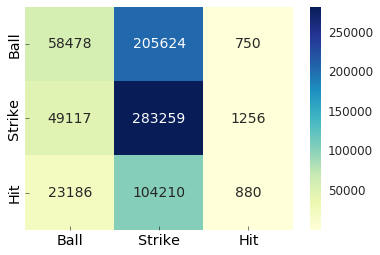

In [22]:
print(model)
print("test loss: {}, test acc: {}".format(dev_loss, dev_acc))
generate_confusion_matrix(test_y, pred_y)

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test = label_binarize(test_y, classes=[0, 1, 2])
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], prob_y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [24]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prob_y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

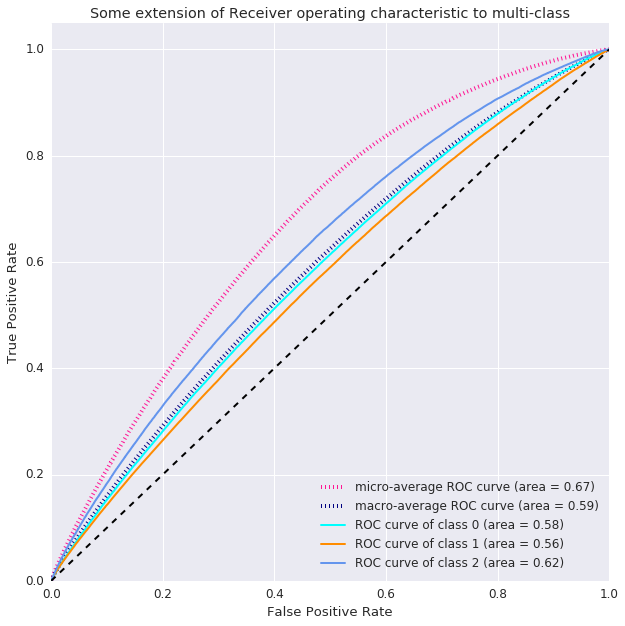

In [28]:
# Compute macro-average ROC curve and ROC area
lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
from sklearn.metrics import f1_score
print("f1_macro: {}, f1_micro: {}".format(f1_score(test_y, pred_y, average='macro'), f1_score(test_y, pred_y, average='micro')))

f1_macro: 0.3067826004849137, f1_micro: 0.4714307336672354
